In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [13]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

input_img = Input(shape=(28, 28, 1))


In [14]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)  # Output 8 channels for extreme chaos

chaos = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
chaos = Conv2D(64, (3, 3), activation='relu', padding='same')(chaos)
chaos = Conv2D(32, (3, 3), activation='relu', padding='same')(chaos)
chaos = Conv2D(32, (3, 3), activation='relu', padding='same')(chaos)
chaos = Conv2D(16, (3, 3), activation='relu', padding='same')(chaos)
chaos = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(chaos)

In [15]:
def add_noise(tensor):
    noise = tf.random.normal(shape=tf.shape(tensor), mean=0.0, stddev=0.3, dtype=tf.float32)
    return tensor + noise

chaos_with_noise = Lambda(add_noise)(chaos)

In [16]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(chaos_with_noise)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output with padding='same'

In [17]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 0.3047 - val_loss: 0.1231
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - loss: 0.1179 - val_loss: 0.1037
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - loss: 0.1025 - val_loss: 0.0969
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - loss: 0.0972 - val_loss: 0.0940
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - loss: 0.0944 - val_loss: 0.0918
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.0924 - val_loss: 0.0907
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.0914 - val_loss: 0.0906
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.0900 - val_loss: 0.0887
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: 0.0895 - val_loss: 0.0886
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.0884 - val_loss: 0.0873
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - loss: 0.0877 - val_loss: 0.0868
Epoch 12/50
469/469 ━━━━━━━━━━

In [18]:
def evaluate_restoration(x_test, decoded_imgs):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []

    for i in range(len(x_test)):
        original = x_test[i].reshape(28, 28)
        restored = decoded_imgs[i].reshape(28, 28)

        # Calculate SSIM
        ssim_score = ssim(original, restored, data_range=1.0)
        ssim_scores.append(ssim_score)

        # Calculate PSNR
        psnr_score = psnr(original, restored)
        psnr_scores.append(psnr_score)

        # Calculate MSE
        mse_score = mean_squared_error(original.flatten(), restored.flatten())
        mse_scores.append(mse_score)

    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)

    return avg_ssim, avg_psnr, avg_mse

In [19]:
encoder_model = Model(input_img, chaos_with_noise)
encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

avg_ssim, avg_psnr, avg_mse = evaluate_restoration(x_test, decoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


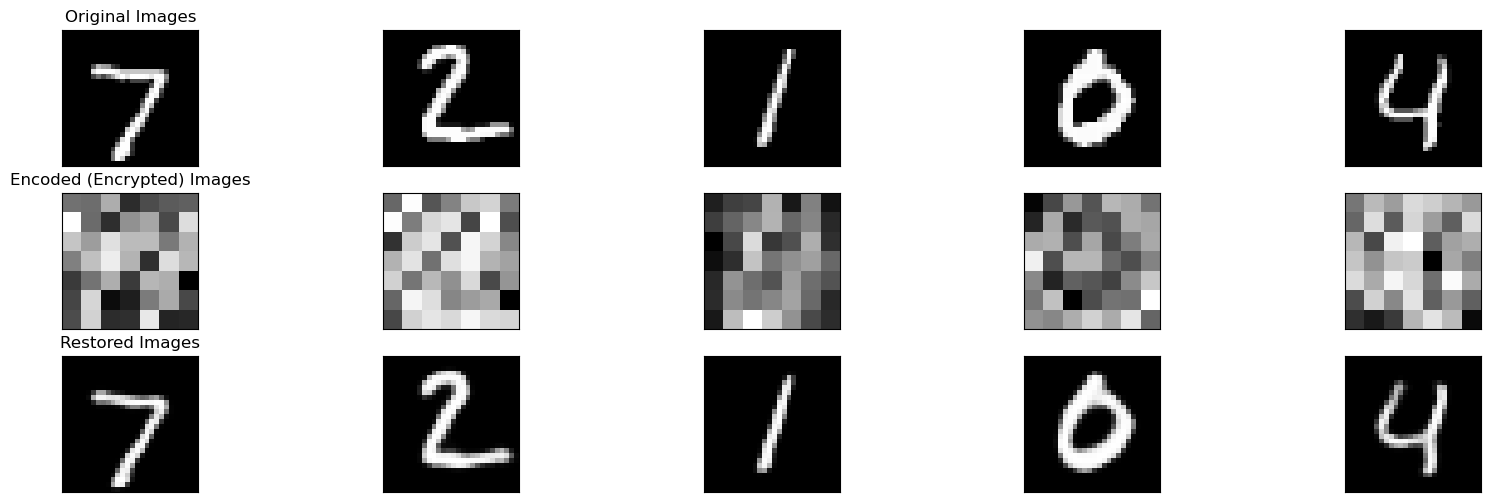

Average SSIM: 0.9334
Average PSNR: 22.5640 dB
Average MSE: 0.0062


In [20]:
n = 5  
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Original Images')

    ax = plt.subplot(3, n, i + 1 + n)
    encoded_img_resized = encoded_imgs[i][:, :, 0]  
    plt.imshow(encoded_img_resized, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Encoded (Encrypted) Images')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Restored Images')
plt.show()

print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f} dB')
print(f'Average MSE: {avg_mse:.4f}')